In [1]:
import string
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import warnings
import plotly.express as px
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import files


uploaded = files.upload()


Saving emails.csv.zip to emails.csv.zip


In [3]:
data_path = "emails.csv.zip"
data = pd.read_csv(data_path)

In [4]:
spam_df = data.copy()
spam_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [6]:
spam_df.describe().T

,count,mean,std,min,25%,50%,75%,max
spam,5728.0,0.238827,0.426404,0.0,0.0,0.0,0.0,1.0


In [7]:
spam_df.dtypes

text    object
spam     int64
dtype: object

In [8]:
duplicate=spam_df[spam_df.duplicated(keep='last')]
duplicate.head()

,text,spam
1417,"Subject: day off tuesday stinson , i would l...",0
1508,Subject: re : enron weather research good aft...,0
1532,Subject: schedule and more . . dr . kaminski ...,0
1667,"Subject: re : summer work . . jinbaek , this...",0
1749,"Subject: term paper dr . kaminski , attached...",0


In [9]:
spam_df=spam_df.rename(columns={'spam':'label'})
spam_df["length"] = spam_df["text"].apply(len)
spam_df.sort_values(by='length', ascending=False).head(3)

,text,label,length
2650,Subject: from the enron india newsdesk - april...,0,43952
1380,Subject: from the enron india newsdesk - april...,0,43937
2338,Subject: from the enron india newsdesk - april...,0,31055


In [11]:
counts = spam_df['label'].value_counts().reset_index()
counts.columns = ['Label', 'Count']
# Create a bar plot using Plotly Express
fig = px.bar(counts, x='Label', y='Count', color='Label')
fig.update_layout(title='Number of Spam and Ham Emails', xaxis_title='Label', yaxis_title='Count')
fig.update_xaxes(tickvals=[0, 1], ticktext=['Ham', 'Spam'])
fig.show()

In [12]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
def preprocess_text(text):
    # Remove punctuation
    no_punctuation = ''.join([char for char in text if char not in string.punctuation])

    # Lowercase the text
    no_punctuation_lower = no_punctuation.lower()

    # Tokenize the text into words
    words = nltk.word_tokenize(no_punctuation_lower)

    # Remove stopwords and non-alphabetic characters, and lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stopwords.words('english') and word.isalpha()]

    # Join the lemmatized words back into a sentence
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [14]:
def preprocess_text(text):
    # Remove punctuation
    no_punctuation = ''.join([char for char in text if char not in string.punctuation])

    # Lowercase the text
    no_punctuation_lower = no_punctuation.lower()

    # Tokenize the text into words
    words = nltk.word_tokenize(no_punctuation_lower)

    # Remove stopwords and non-alphabetic characters, and lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stopwords.words('english') and word.isalpha()]

    # Join the lemmatized words back into a sentence
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

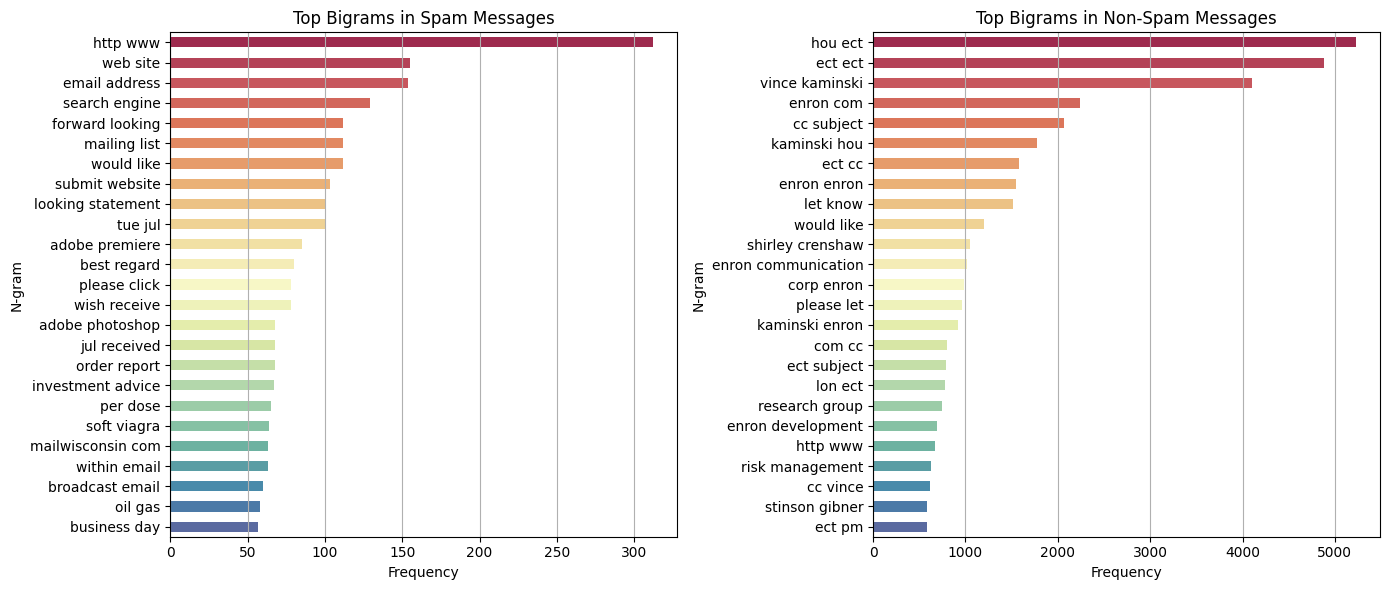

In [17]:
def plot_ngrams(ax, texts, ngram_range=(2, 2), num_top_ngrams=25, title=''):
    # Initialize count vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    # Fit and transform the texts
    X = vectorizer.fit_transform(texts)
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    # Sum the occurrences of each n-gram
    ngram_counts = X.sum(axis=0).A1
    # Create a dictionary of n-grams and their counts
    ngram_dict = dict(zip(feature_names, ngram_counts))
    # Sort the dictionary by counts in descending order
    sorted_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)
    # Select top N n-grams
    top_ngrams = sorted_ngrams[:num_top_ngrams]
    # Plot the top N n-grams
    sns.barplot(ax=ax, x=[ngram[1] for ngram in top_ngrams],
                y=[ngram[0] for ngram in top_ngrams],
                orient="h",
                width=0.5,
                palette='Spectral')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-gram')
    ax.set_title(title)

# Filter spam and non-spam messages
spam_texts = spam_df[spam_df['label'] == 1]['preprocessed_text']
non_spam_texts = spam_df[spam_df['label'] == 0]['preprocessed_text']

#Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ngrams(axes[0], spam_texts, title='Top Bigrams in Spam Messages')
plot_ngrams(axes[1], non_spam_texts, title='Top Bigrams in Non-Spam Messages')
axes[0].grid(axis='x')
axes[1].grid(axis='x')
plt.tight_layout()
plt.show()

In [16]:
spam_df["preprocessed_text"] = spam_df["text"].apply(preprocess_text)
spam_df.head()

,text,label,length,preprocessed_text
0,Subject: naturally irresistible your corporate...,1,1484,subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,1,598,subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,1,448,subject unbelievable new home made easy im wan...
3,Subject: 4 color printing special request add...,1,500,subject color printing special request additio...
4,"Subject: do not have money , get software cds ...",1,235,subject money get software cd software compati...


In [18]:
vectorizer = CountVectorizer()
# Bag of words
bow_text = vectorizer.fit_transform(spam_df["preprocessed_text"])
# Fetch the vocabulary set
print(f"10 Bag Of Words Features: {vectorizer.get_feature_names_out()[100:110]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

10 Bag Of Words Features: ['absorb' 'absorbing' 'absorbowac' 'absorbs' 'absorption' 'absoutely'
 'abspielt' 'abstained' 'abstract' 'abstractive']
Total number of vocab words: 30962


In [21]:
transformed_bow = vectorizer.transform(spam_df["preprocessed_text"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences
print(f"Shape of sparse matrix: {transformed_bow.shape}")
print(f"Amount of non-zero occurrences: {transformed_bow.nnz}")

Shape of sparse matrix: (5728, 30962)
Amount of non-zero occurrences: 490058


In [22]:
tfidf_transformer = TfidfTransformer().fit(transformed_bow)
# Transform entire BoW into tf-idf corpus
text_tfidf = tfidf_transformer.transform(transformed_bow)
print(text_tfidf.shape)

(5728, 30962)


In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    text_tfidf, spam_df["label"], test_size=0.2
)

print(f"train dataset features size: {x_train.shape}")
print(f"train dataset label size: {y_train.shape}")

print(f"test dataset features size: {x_test.shape}")
print(f"test dataset label size: {y_test.shape}")

train dataset features size: (4582, 30962)
train dataset label size: (4582,)
test dataset features size: (1146, 30962)
test dataset label size: (1146,)


In [24]:
def evaluate_model(model, x_test, y_test, model_name="Model"):

  # Predict labels on testing data
  y_pred = model.predict(x_test)

  # Calculate confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)

  # Extract TP, TN, FP, FN
  TN, FP, FN, TP = conf_matrix.ravel()

  # Calculate various performance metrics
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  specificity = TN / (TN + FP)
  miss_rate = FN / (FN + TP)

  # Calculate mean accuracy using cross-validation
  mean_accuracy = cross_val_predict(model, x_train, y_train, cv=10).mean()

  # Calculate mean square error (for regression tasks, not applicable here)
  mse = mean_squared_error(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, output_dict=True)
  metrics = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-score": f1,
        "Specificity": specificity,
        "Miss Rate": miss_rate,
        "Mean Accuracy": mean_accuracy,
        "Mean Square Error": mse,
        "Classification Report": classification_rep
    }
  # Print evaluation metrics
  print(f"\033[1m EVALUATION METRICS ({model_name}) \033[0m")
  print(f"\n \033 ---------------------------------------------------------------- \033[0m")
  print("\nTrue Positives (TP):", TP)
  print("True Negatives (TN):", TN)
  print("False Positives (FP):", FP)
  print("False Negatives (FN):", FN)
  print("\nAccuracy   : ", accuracy)
  print("Recall       : ", recall)
  print("Precision    : ", precision)
  print("F1-score     : ", f1)
  print("Specificity  : ", specificity)
  print("Miss Rate    : ", miss_rate)
  print("Mean Accuracy: ", mean_accuracy)
  print("Mean Square Error:", mse)  # Not applicable for classification
  print(f" \033 ---------------------------------------------------------------- \033[0m")

  # Print classification report
  print("\033[1m Classification Report: \033[0m")
  print(classification_report(y_test, y_pred))
  print(f"\n \033 ---------------------------------------------------------------- \033[0m")
  print("\033[1m Confusion Matrix \033[0m")
  # Plot the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
  disp.plot(cmap='bone_r')  # specify the colormap for better visualization
  plt.show()
  return metrics,y_pred

 EVALUATION METRICS (SVM) 

  ---------------------------------------------------------------- 

True Positives (TP): 247
True Negatives (TN): 890
False Positives (FP): 3
False Negatives (FN): 6

Accuracy   :  0.9921465968586387
Recall       :  0.9762845849802372
Precision    :  0.988
F1-score     :  0.9821073558648111
Specificity  :  0.9966405375139977
Miss Rate    :  0.023715415019762844
Mean Accuracy:  0.23374072457442166
Mean Square Error: 0.007853403141361256
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       893
           1       0.99      0.98      0.98       253

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146


  ---------------------------------------------------------------- 
 Confusion Matrix 


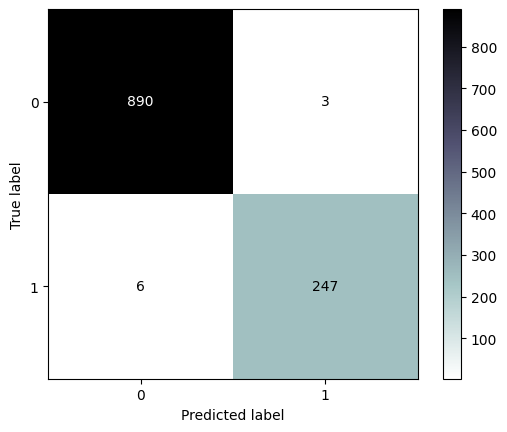

In [25]:
svm_model = SVC()
svm_model.fit(x_train, y_train)
# Evaluate SVM model
svm_metrics,y_pred_svm = evaluate_model(svm_model, x_test, y_test, model_name="SVM")